# Fast AI Agents with a Semantic Cache

In this final lab, you’ll integrate your semantic cache into an AI agent so it can reuse past results, skip redundant work, and get faster over time.

In [1]:
# Warning control
import warnings
warnings.filterwarnings('ignore')

## Setup Environment

In [2]:
from cache.llm_evaluator import set_openai_key

set_openai_key()

In [3]:
import logging
import time
import json
import numpy as np
import pandas as pd
from datetime import datetime
from typing import List, Dict, Any, Optional

from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import StateGraph, END, START

import redis
from redisvl.utils.vectorize import HFTextVectorizer, OpenAITextVectorizer
from redisvl.extensions.cache.llm import SemanticCache
from redisvl.index import SearchIndex
from redisvl.query import VectorQuery

logging.basicConfig(
    level=logging.INFO, format="%(asctime)s | %(levelname)s | %(message)s"
)
logger = logging.getLogger("agentic-workflow")

## Setup Redis Infra

In [4]:
redis_client = redis.Redis.from_url(
    "redis://localhost:6379", decode_responses=False
)
redis_client.ping()

True

### Build the Agent Knowledge Base (for RAG)


In [5]:
from agent import create_knowledge_base_from_texts
from agent.knowledge_base_utils import FreeTextVectorizer


embeddings = FreeTextVectorizer()

raw_docs = [
    "Our premium support plan includes 24/7 phone support, priority email response within 2 hours, and dedicated account management. Premium support costs $49/month.",
    "Account upgrade process: Go to Account Settings → Plan & Billing → Select Upgrade. Available plans: Basic $9/month, Pro $29/month, Enterprise $99/month.",
    "API rate limits by plan: Free tier 100 requests/hour, Basic 1,000 requests/hour, Pro 10,000 requests/hour, Enterprise unlimited with fair-use policy.",
    "Data export options: CSV, JSON, XML formats supported. Large exports (>1GB) may take up to 24 hours to process.",
    "Third-party integrations: Native support for Slack, Microsoft Teams, Zoom, Salesforce, HubSpot. 200+ additional integrations available via Zapier.",
    "Security features: SOC2 compliance, end-to-end encryption, GDPR compliance, SSO integration, audit logs, IP whitelisting.",
    "Billing and payments: We accept all major credit cards, PayPal, and ACH transfers. Enterprise customers can pay by invoice with NET30 terms.",
    "Account recovery: Use forgot password link, verify email, or contact support with account verification details. Response within 4 hours.",
]

success, message, kb_index = create_knowledge_base_from_texts(
    texts=raw_docs,
    source_id="customer_support_docs",
    redis_url="redis://localhost:6379",
    skip_chunking=True,
)

INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cpu
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2
INFO:kb-utils:Loaded all-MiniLM-L6-v2 with 384 dimensions
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cpu
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2
INFO:kb-utils:Loaded all-MiniLM-L6-v2 with 384 dimensions
INFO:kb-utils:Using embeddings with 384 dimensions
INFO:kb-utils:Using provided list of 8 text chunks
INFO:redisvl.index.index:Index already exists, overwriting.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:kb-utils:✅ Created knowledge base with 8 chunks (text_list)


### Build the Semantic Cache

In [6]:
from cache.wrapper import SemanticCacheWrapper
from cache.config import config
from cache.cross_encoder import CrossEncoder
from cache.faq_data_container import FAQDataContainer

cache = SemanticCacheWrapper.from_config(config)

data = FAQDataContainer()
cache.hydrate_from_df(data.faq_df, clear=True)

INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cpu
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: redis/langcache-embed-v1


✅ Redis is running and accessible!


INFO:redisvl.index.index:Index already exists, not overwriting.


Loaded 8 FAQ entries
Loaded 80 test queries


## Build the LangGraph Agent

In [7]:
from agent import (
    WorkflowState,
    initialize_agent,
    decompose_query_node,
    check_cache_node,
    research_node,
    evaluate_quality_node,
    synthesize_response_node,
    route_after_cache_check,
    route_after_quality_evaluation,
)

initialize_agent(cache, kb_index, embeddings)

In [8]:
workflow = StateGraph(WorkflowState)

# Add nodes 
workflow.add_node("decompose_query", decompose_query_node)
workflow.add_node("check_cache", check_cache_node)
workflow.add_node("research", research_node)
workflow.add_node("evaluate_quality", evaluate_quality_node)
workflow.add_node("synthesize", synthesize_response_node)

# Set entry point to decomposition node
workflow.set_entry_point("decompose_query")

# Add edges
workflow.add_edge("decompose_query", "check_cache")
workflow.add_conditional_edges(
    "check_cache",
    route_after_cache_check,
    {
        "research": "research",  # Go to research if cache misses
        "synthesize": "synthesize",  # Skip to synthesis if all cached
    },
)
workflow.add_edge("research", "evaluate_quality")
workflow.add_conditional_edges(
    "evaluate_quality",
    route_after_quality_evaluation,
    {
        "research": "research",
        "synthesize": "synthesize",
    },
)
workflow.add_edge("synthesize", END)

workflow_app = workflow.compile()

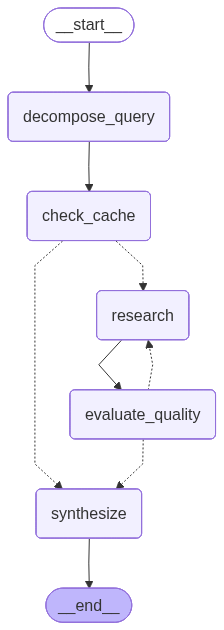

In [9]:
from IPython.display import Image, display

display(Image(workflow_app.get_graph().draw_mermaid_png()))

## Demo the Agent

In [10]:
from agent import display_results
from agent import run_agent

### Scenario 1: Enterprise Platform Evaluation (cache building phase)


In [11]:
scenario1_query = """
I'm evaluating your platform for our enterprise needs. We need to understand your 
security and compliance standards including SOC2 status, want to know the API rate 
limits for the Pro plan since we're considering that tier, need details about 
Salesforce integration capabilities, and want to understand your payment options 
including whether you support ACH transfers.
"""

result1 = run_agent(workflow_app, scenario1_query)
display_results(result1)

INFO:agentic-workflow:================================================================================
INFO:agentic-workflow:🧠 Decomposing query...
INFO:agentic-workflow:🧠 Supervisor: Decomposing query: '
I'm evaluating your platform for our enterprise n...'
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:agentic-workflow:🧠 Query is simple - keeping as single question
INFO:agentic-workflow:🧠 Kept as single question in 10096.79ms
INFO:agentic-workflow:🧠 Query decomposition complete
INFO:agentic-workflow:🔍 Supervisor: Checking cache for 1 sub-questions
INFO:agentic-workflow:   ❌ Cache MISS: '
I'm evaluating your platform for our en...'
INFO:agentic-workflow:🔍 Cache check complete: 0/1 hits (0.0%) in 30.38ms
INFO:agentic-workflow:🔀 Routing to researcher: 1 cache misses detected
INFO:agentic-workflow:   🔍 Will research: '
I'm evaluating your platform for our enterprise n...'
INFO:agentic-workflow:🔬 Research: Starting investigation with strategy adaptati

\n🎯 SEMANTIC CACHING WORKFLOW ANALYSIS
📝 **Original Query:** 
I'm evaluating your platform for our enterprise needs. We need to understand your 
security and com...
🔄 **Execution Path:** decomposed → cache_checked → research_failed → quality_evaluated → synthesized
\n🧠 **Query Decomposition:** 1 sub-questions
   1. 🔍 **RESEARCH**: 
I'm evaluating your platform for our enterprise needs. We need to understand your 
security and compliance standards including SOC2 status, want to know the API rate 
limits for the Pro plan since we're considering that tier, need details about 
Salesforce integration capabilities, and want to understand your payment options 
including whether you support ACH transfers.

\n📊 **Performance Metrics:**
   💾 Cache Hit Rate: **0.0%** (0/1 questions)
   🤖 LLM Calls: **3** (GPT-4: 2, GPT-4-Mini: 1)
   ⚡ Total Latency: **15815.80ms**
   ⏱️  Cache: 30ms, Research: 0ms
\n📋 **AI Response:**
-------------------------------------------------------------------------------

I'm sorry to hear about your experience. I'll do my best to assist you with this query. Please provide me with more details so I can better understand your needs and help you find the information you're looking for.

--------------------------------------------------------------------------------


### Scenario 2: Implementation Planning (partial cache hits likely)

In [12]:
scenario2_query = """
We're moving forward with implementation planning. I need to compare API rate limits 
between Pro and Enterprise plans to decide on our tier, confirm the Salesforce 
integration capabilities we discussed, understand what data export options you provide 
for our migration needs, and verify the payment methods including ACH since our 
accounting team prefers that for monthly billing.
"""

result2 = run_agent(workflow_app, scenario2_query)
display_results(result2)

INFO:agentic-workflow:================================================================================
INFO:agentic-workflow:🧠 Decomposing query...
INFO:agentic-workflow:🧠 Supervisor: Decomposing query: '
We're moving forward with implementation planning...'
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:agentic-workflow:🧠 Query is simple - keeping as single question
INFO:agentic-workflow:🧠 Kept as single question in 472.06ms
INFO:agentic-workflow:🧠 Query decomposition complete
INFO:agentic-workflow:🔍 Supervisor: Checking cache for 1 sub-questions
INFO:agentic-workflow:   ✅ Cache HIT: '
We're moving forward with implementatio...' (confidence: 0.893)
INFO:agentic-workflow:🔍 Cache check complete: 1/1 hits (100.0%) in 14.89ms
INFO:agentic-workflow:🔀 Routing to synthesis: all sub-questions cached!
INFO:agentic-workflow:🔗 Supervisor: Synthesizing 1 answers into final response
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK

\n🎯 SEMANTIC CACHING WORKFLOW ANALYSIS
📝 **Original Query:** 
We're moving forward with implementation planning. I need to compare API rate limits 
between Pro a...
🔄 **Execution Path:** decomposed → cache_checked → synthesized
\n🧠 **Query Decomposition:** 1 sub-questions
   1. ✅ **CACHE HIT** (0.893): 
We're moving forward with implementation planning. I need to compare API rate limits 
between Pro and Enterprise plans to decide on our tier, confirm the Salesforce 
integration capabilities we discussed, understand what data export options you provide 
for our migration needs, and verify the payment methods including ACH since our 
accounting team prefers that for monthly billing.

\n📊 **Performance Metrics:**
   💾 Cache Hit Rate: **100.0%** (1/1 questions)
   🤖 LLM Calls: **2** (GPT-4: 2, GPT-4-Mini: 0)
   ⚡ Total Latency: **3233.45ms**
   ⏱️  Cache: 15ms, Research: 0ms
\n📋 **AI Response:**
--------------------------------------------------------------------------------


Hi there! I'm here to help you with your implementation planning. To compare API rate limits between Pro and Enterprise plans, we need to confirm the Salesforce integration capabilities discussed. We also need to understand what data export options you provide for our migration needs. Lastly, we need to verify the payment methods including ACH since our accounting team prefers that for monthly billing. Please contact support for assistance.

--------------------------------------------------------------------------------


### Scenario 3: Pre-Purchase Comprehensive Review (many cache hits expected)

In [13]:
scenario3_query = """
Before finalizing our Pro plan purchase, I need complete validation on: your security 
compliance framework including SOC2 requirements, the exact API rate limits for the 
Pro plan we're purchasing, confirmation of the Salesforce integration features, all 
supported payment methods since we want to use ACH transfers, and your data export 
capabilities for our future migration planning.
"""

result3 = run_agent(workflow_app, scenario3_query)
display_results(result3)

INFO:agentic-workflow:================================================================================
INFO:agentic-workflow:🧠 Decomposing query...
INFO:agentic-workflow:🧠 Supervisor: Decomposing query: '
Before finalizing our Pro plan purchase, I need c...'
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:agentic-workflow:🧠 Decomposed into 4 sub-questions in 3236.75ms
INFO:agentic-workflow:   1. Why do I need to complete validation on your security compliance framework including SOC2 requirements?
INFO:agentic-workflow:   2. What is the exact API rate limits for the Pro plan we're purchasing?
INFO:agentic-workflow:   3. Can you confirm the Salesforce integration features that support our migration planning?
INFO:agentic-workflow:   4. Do you have all supported payment methods since we want to use ACH transfers?
INFO:agentic-workflow:🧠 Query decomposition complete
INFO:agentic-workflow:🔍 Supervisor: Checking cache for 4 sub-questions
INFO:agentic-wor

\n🎯 SEMANTIC CACHING WORKFLOW ANALYSIS
📝 **Original Query:** 
Before finalizing our Pro plan purchase, I need complete validation on: your security 
compliance f...
🔄 **Execution Path:** decomposed → cache_checked → research_failed → quality_evaluated → synthesized
\n🧠 **Query Decomposition:** 4 sub-questions
   1. 🔍 **RESEARCH**: Why do I need to complete validation on your security compliance framework including SOC2 requirements?
   2. 🔍 **RESEARCH**: What is the exact API rate limits for the Pro plan we're purchasing?
   3. 🔍 **RESEARCH**: Can you confirm the Salesforce integration features that support our migration planning?
   4. 🔍 **RESEARCH**: Do you have all supported payment methods since we want to use ACH transfers?
\n📊 **Performance Metrics:**
   💾 Cache Hit Rate: **0.0%** (0/4 questions)
   🤖 LLM Calls: **6** (GPT-4: 2, GPT-4-Mini: 4)
   ⚡ Total Latency: **20949.18ms**
   ⏱️  Cache: 310ms, Research: 0ms
\n📋 **AI Response:**
-----------------------------------------------

Sure, I understand your concern. Before finalizing our Pro plan purchase, please complete validation on your security compliance framework including SOC2 requirements. The exact API rate limits for the Pro plan we're purchasing should be confirmed. Please contact support for assistance with Salesforce integration features and payment methods since we want to use ACH transfers. Lastly, do you have all supported payment methods since we want to use ACH transfers?

--------------------------------------------------------------------------------


## Agent Performance Analysis


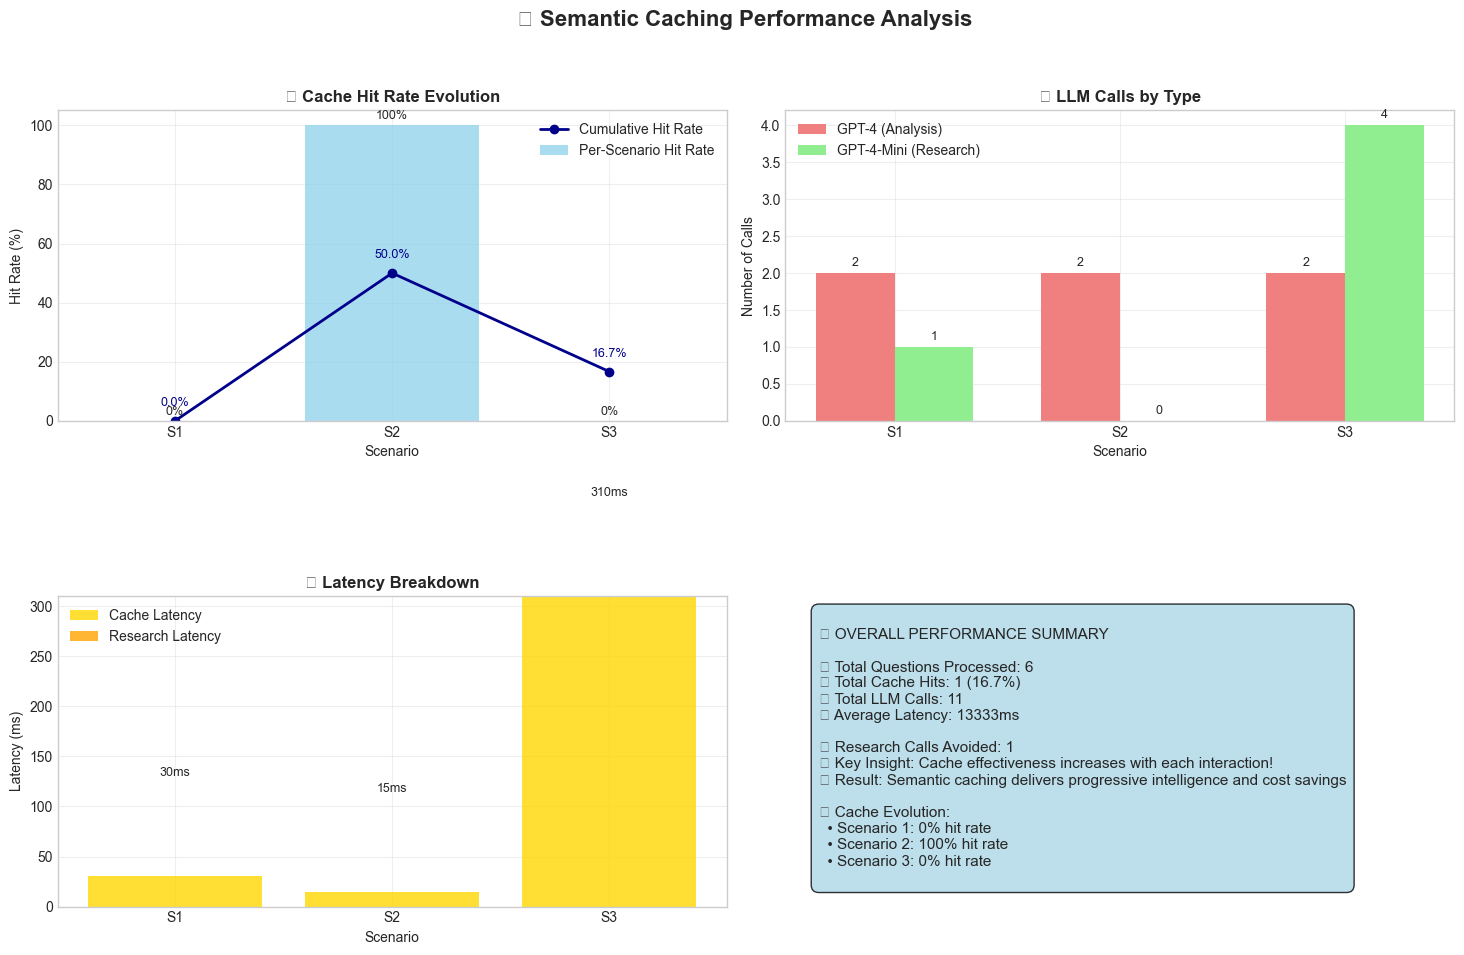

In [14]:
import warnings
warnings.simplefilter("ignore")

from agent import analyze_agent_results

total_questions, total_cache_hits = analyze_agent_results(
    [result1, result2, result3]
)

## Interactive Demo


Here is the link we used in the video for this section:
* https://att.com/international

In [15]:
from agent import launch_demo


launch_demo(
    workflow_app,
    cache,
    share=True,
    height=1500,
    inline=True
)

INFO:demo:Using Tavily API key from environment
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cpu
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2
INFO:kb-utils:Loaded all-MiniLM-L6-v2 with 384 dimensions
INFO:kb-utils:Using embeddings with 384 dimensions
INFO:httpx:HTTP Request: GET https://api.gradio.app/pkg-version "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET http://127.0.0.1:7860/gradio_api/startup-events "HTTP/1.1 200 OK"


* Running on local URL:  http://127.0.0.1:7860


INFO:httpx:HTTP Request: HEAD http://127.0.0.1:7860/ "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.gradio.app/v3/tunnel-request "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://cdn-media.huggingface.co/frpc-gradio-0.3/frpc_windows_amd64.exe "HTTP/1.1 200 OK"



Could not create share link. Please check your internet connection or our status page: https://status.gradio.app.


In [ ]:
cache.cache.check(
    "checking cache", distance_threshold=1.0, num_results=100
)

[{'entry_id': '6951ac186c3c6207f25a11ebc9bd96c888b38fa33838cd138e1366e836a36ed7',
  'prompt': 'Where is my order?',
  'response': 'Use the tracking link sent to your email after shipping. Orders typically arrive within 2-7 business days depending on your location.',
  'vector_distance': 0.477181017399,
  'inserted_at': 1763935918.83,
  'updated_at': 1763935918.83,
  'key': 'semantic-cache:6951ac186c3c6207f25a11ebc9bd96c888b38fa33838cd138e1366e836a36ed7'},
 {'entry_id': '60fd55b8527fcd2bf427d81dc3f4c47c4bf8904c9802ffecbcf2c02b38f537ac',
  'prompt': 'How do I get a refund?',
  'response': 'To request a refund, visit your orders page and select **Request Refund**. Refunds are processed within 3-5 business days.',
  'vector_distance': 0.481174886227,
  'inserted_at': 1763935918.8,
  'updated_at': 1763935918.8,
  'key': 'semantic-cache:60fd55b8527fcd2bf427d81dc3f4c47c4bf8904c9802ffecbcf2c02b38f537ac'},
 {'entry_id': '6e256e6e56a2afb5d089be3cb4cc51ada871f547f333616d9dd261e1fcca5e20',
  'prom

INFO:demo:🧹 Complete reset: cleared knowledge bases and semantic cache
INFO:demo:Reset status: 🧹 Reset complete: ✅ Cleared 0 knowledge bases, semantic cache cleared
INFO:kb-utils:Split text into 30 chunks


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:kb-utils:✅ Created knowledge base with 30 chunks (text_chunked)
INFO:agentic-workflow:================================================================================
INFO:agentic-workflow:🧠 Decomposing query...
INFO:agentic-workflow:🧠 Supervisor: Decomposing query: 'What is difference between langchain and langgraph...'
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:agentic-workflow:🧠 Query is simple - keeping as single question
INFO:agentic-workflow:🧠 Kept as single question in 724.55ms
INFO:agentic-workflow:🧠 Query decomposition complete
INFO:agentic-workflow:🔍 Supervisor: Checking cache for 1 sub-questions
INFO:agentic-workflow:   ❌ Cache MISS: 'What is difference between langchain and...'
INFO:agentic-workflow:🔍 Cache check complete: 0/1 hits (0.0%) in 337.12ms
INFO:agentic-workflow:🔀 Routing to researcher: 1 cache misses detected
INFO:agentic-workflow:   🔍 Will research: 'What is difference between langchain and langgraph...'
INFO:agenti